# Creating Dataset

This notebook is about creating a network train dataset with input <code>[eta,deta,dphi,theta,qop,pt,phi,z0,dz0,do,dhadpt,q,n]</code> and lebel efficiency<br>
The code is about creating a tensor contains tensor contain input e.g. <code>[input1,input2,...]</code> and tensor with lebel <code>[eff1,eff2,....]</code><br>
Then choose some of the data in the tensor to be the test dataset and the rest train dataset

## Import lib needed

In [18]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

In [19]:
# load data
# ref main.ipynb

data = np.load("testevals/data_100k.npz")

# Convert the data from dumpy arrays to pytorch tensors
data = {k: torch.from_numpy(v) for k, v in data.items()}

In [20]:
# ref plot.py
from metrics import calc_match_scores

def calc_scores(reco_method,match_thresh = 0.75):
    match_metric = "tmp"

    pred_pix_valid = data[f"{reco_method}_pix_valid"]
    pred_sct_valid = data[f"{reco_method}_sct_valid"]
    pred_valid = data[f"{reco_method}_valid"]

    true_pix_valid = data["sudo_pix_valid"]
    true_sct_valid = data["sudo_sct_valid"]
    true_valid = data["sudo_valid"]

    match_score = calc_match_scores(pred_pix_valid, pred_sct_valid, pred_valid, true_pix_valid, true_sct_valid, true_valid, match_metric)
    matches = match_score  >= match_thresh

    true_has_match = matches.any(1) & true_valid
    pred_has_match = matches.any(2) & pred_valid
        
    true_num = true_valid.sum(-1)
    pred_num = pred_valid.sum(-1)
        
    true_num_matched = true_has_match.sum(-1)
    pred_num_matched = pred_has_match.sum(-1)

    roi_eff = true_num_matched / true_num # matched num / true num
    roi_pur = pred_num_matched / pred_num # matched num / predicted num
    print(roi_eff)
    print(roi_pur)
    return pred_has_match , roi_eff, roi_pur

pred_pred_has_match, pred_roi_eff, pred_roi_pur = calc_scores("pred")
sisp_pred_has_match, sisp_roi_eff, sisp_roi_pur = calc_scores("sisp")
reco_pred_has_match, reco_roi_eff, reco_roi_pur = calc_scores("reco")
sudo_pred_has_match, sudo_roi_eff, sudo_roi_pur = calc_scores("sudo")

pred_has_match = {"pred":pred_pred_has_match,"sisp":sisp_pred_has_match,"reco":reco_pred_has_match,"sudo":sudo_pred_has_match}
roi_pur = {"pred":pred_roi_pur,"sisp":sisp_roi_pur,"reco":reco_roi_pur,"sudo":sudo_roi_pur}
roi_eff = {"pred":pred_roi_eff,"sisp":sisp_roi_eff,"reco":reco_roi_eff,"sudo":sudo_roi_eff}

tensor([1.0000, 0.8462, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
tensor([0.8889, 1.0000, 0.7333,  ..., 0.6667, 0.4000, 0.3333])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
tensor([0.5333, 0.8667, 0.5263,  ..., 0.5000, 0.1429, 0.1111])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
tensor([0.8889, 1.0000, 0.9091,  ..., 0.5714, 0.5000, 1.0000])
tensor([1., 1., 1.,  ..., 1., 1., 1.])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [21]:
def calculate_quanity(qtys = "deta"):
    matched_reco = torch.tensor([])
    unmatched_reco = torch.tensor([])

    for idx in range(pred_has_match["pred"].shape[0]):
        #print(pred_has_match["pred"][idx] )
        #print(data["pred_valid"][idx])
        matched_reco = torch.cat((matched_reco,data[f"sudo_{qtys}"][idx][pred_has_match["pred"][idx] & data["pred_valid"][idx]]),0)
        unmatched_reco = torch.cat((unmatched_reco,data[f"sudo_{qtys}"][idx][~pred_has_match["pred"][idx] & data["pred_valid"][idx]]),0)
    
    return matched_reco, unmatched_reco

In [22]:
# Test the funciton
matched_data, unmatched_data = calculate_quanity()
print(matched_data)
print(matched_data.shape)
print(unmatched_data)
print(unmatched_data.shape)

tensor([ 0.0068, -0.0181, -0.0008,  ...,  0.0457,  0.0000,  0.0426])
torch.Size([602222])
tensor([0.0000, 0.0270, 0.0000,  ..., 0.0000, 0.0000, 0.0000])
torch.Size([102527])


In [23]:
# Calculate number of hits of reconstructed tracks
def calculate_hits():
    hit_matched = torch.tensor([])
    hit_unmatched = torch.tensor([])
    for idx in range(pred_has_match["pred"].shape[0]):
        for idx2 in range(data["pred_valid"][idx].shape[0]):
            if data["pred_valid"][idx][idx2]:
                #print(pred_has_match["pred"][idx][idx2])
                if pred_has_match["pred"][idx][idx2]:
                    #print(data["sudo_pix_valid"][idx][idx2])
                    hit = torch.tensor([data["pred_pix_valid"][idx][idx2].count_nonzero()+data["pred_sct_valid"][idx][idx2].count_nonzero()])
                    hit_matched = torch.cat((hit_matched,hit),dim=0)
                else:
                    hit = torch.tensor([data["pred_pix_valid"][idx][idx2].count_nonzero()+data["pred_sct_valid"][idx][idx2].count_nonzero()])
                    hit_unmatched = torch.cat((hit_unmatched,hit),dim=0)
                    #print(hit)
    #print(hit_matched)
    #print(hit_matched.shape)
    #print(hit_unmatched)
    #print(hit_unmatched.shape)
    return hit_matched, hit_unmatched

In [24]:
calculate_hits()

(tensor([12., 11., 12.,  ...,  4.,  4., 15.]),
 tensor([13.,  9.,  8.,  ...,  4., 17., 14.]))

Seems we have 60438 matched track and 9874 unmatched track<br>
I choose first 3k matched track and first 500 unmatched data as my test dataset

In [25]:
num_test_good = 30000 # let first 3k of the good reco track be test set
num_test_bad = 5000 # let first 500 of the bad reco track be test set

In [26]:
quantity = ["pt","eta","deta","phi","dphi","theta","z0","dz0","d0","q","qop","bhadpt"]

data_test_label = torch.cat((torch.tensor([1,0]).repeat(num_test_good,1),torch.tensor([0,1]).repeat(num_test_bad,1)),dim = 0)
data_train_label_good_reco = torch.tensor([1,0]).repeat(matched_data.shape[0]-num_test_good,1)
data_train_label_bad_reco = torch.tensor([0,1]).repeat(unmatched_data.shape[0]-num_test_bad,1)
data_train_label = torch.cat([data_train_label_good_reco,data_train_label_bad_reco],dim = 0)
#data_test_input = torch.cat((hit_matched[0:3000],hit_unmatched[0:300]))



In [27]:
hit_matched, hit_unmatched = calculate_hits()
pt_matched , pt_unmatched = calculate_quanity("pt")
eta_matched , eta_unmatched = calculate_quanity("eta")
#deta_matched , deta_unmatched = calculate_quanity("deta")
phi_matched , phi_unmatched = calculate_quanity("phi")
#dphi_matched , dphi_unmatched = calculate_quanity("dphi")
theta_matched , theta_unmatched = calculate_quanity("theta")
#z0_matched , z0_unmatched = calculate_quanity("z0")
#dz0_matched , dz0_unmatched = calculate_quanity("dz0")
#d0_matched , d0_unmatched = calculate_quanity("d0")
#q_matched , q_unmatched = calculate_quanity("q")
#qop_matched , qop_unmatched = calculate_quanity("qop")
#bhadpt_matched , bhadpt_unmatched = calculate_quanity("bhadpt")

In [28]:
pt_max = np.log10(torch.max(pt_matched+1e-6))
pt_min = np.log10(torch.min(pt_matched+1e-6))
print(pt_max+pt_min)
print(pt_max-pt_min)


print(torch.max(pt_matched/3.0e4))

tensor(-1.5369)
tensor(10.4631)
tensor(0.9682)


In [29]:
data_input_good = torch.tensor([])
data_input_bad = torch.tensor([])
for i in range(matched_data.shape[0]):
    if np.abs(eta_matched[i]) < 1.5:
        data_input_good = torch.cat((data_input_good,torch.tensor([[hit_matched[i]/18,
                                 pt_matched[i]/3.0e4,
                                 0.5 + eta_matched[i]/5,
                                 #0.5 + deta_matched[i]/0.1,
                                 0.5 + phi_matched[i]/(2*np.pi),
                                 #0.5 + dphi_matched[i]/0.1,
                                 theta_matched[i]/np.pi,
                                 #z0_matched[i],
                                 #dz0_matched[i],
                                 #d0_matched[i],
                                 #q_matched[i],
                                 #0.5 + qop_matched[i]/1,
                                 #bhadpt_matched[i],
                                 ]])),dim = 0)
for i in range(unmatched_data.shape[0]):
        data_input_bad = torch.cat((data_input_bad,torch.tensor([[hit_unmatched[i]/18,
                                 pt_unmatched[i]/3.0e4,
                                 0.5 + eta_unmatched[i]/5,
                                 #0.5 + deta_unmatched[i]/0.1,
                                 0.5 + phi_unmatched[i]/(2*np.pi),
                                 #0.5 + dphi_unmatched[i]/0.1,
                                 theta_unmatched[i]/np.pi,
                                 #z0_unmatched[i],
                                 #dz0_unmatched[i],
                                 #d0_unmatched[i],
                                 #q_unmatched[i],
                                 #0.5 + qop_unmatched[i]/1,
                                 #bhadpt_unmatched[i],
                                 ]])),dim = 0)
print(data_input_good.shape)
print(data_input_bad.shape)

torch.Size([566207, 5])
torch.Size([102527, 5])


torch.Size([566207])


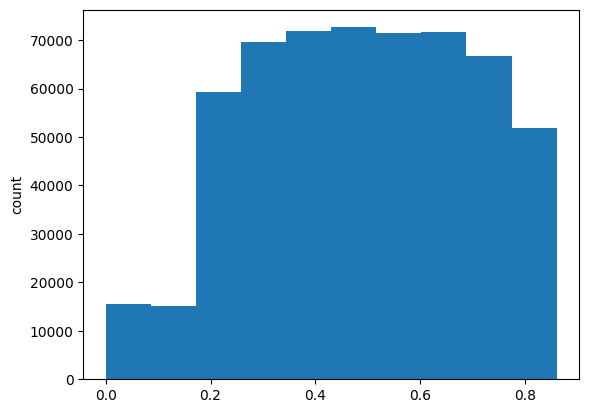

torch.Size([102527])


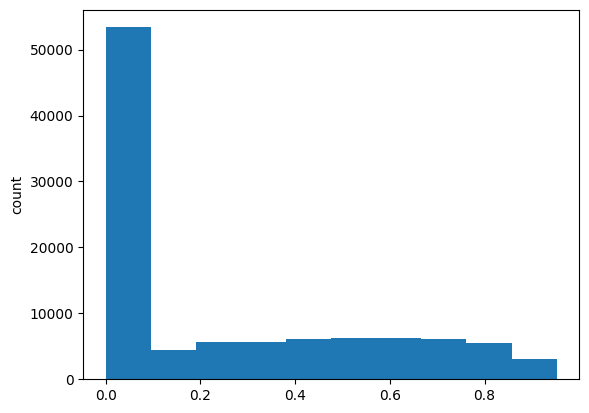

In [30]:
#print histogram on eta

eta_his = data_input_good[:,4]
print(eta_his.shape)

plt.hist(eta_his)
#plt.xlabel("eta_number")
plt.ylabel("count")
plt.show()

eta_his = data_input_bad[:,4]
print(eta_his.shape)

plt.hist(eta_his)
#plt.xlabel("eta_number")
plt.ylabel("count")
plt.show()

In [31]:
# applying filter

data_good_filted_index = torch.zeros(data_input_good.shape[0], dtype=torch.bool)
data_bad_filted_index = torch.zeros(data_input_bad.shape[0], dtype=torch.bool)



for i in range (data_input_good.shape[0]):
    if True:#data_input_good[i,1]<0.1 and data_input_good[i,0]<0.8 and data_input_good[i,0]>0.6 and data_input_good[i,4]<0.6 and data_input_good[i,4]>0.4: #np.abs(eta_matched[i]) < 1.5:
        data_good_filted_index[i] = True

for i in range (data_input_bad.shape[0]):
    if True:#data_input_bad[i,1]<0.1 and data_input_bad[i,0]<0.8 and data_input_bad[i,0]>0.6 and data_input_bad[i,4]<0.6 and data_input_bad[i,4]>0.4: #np.abs(eta_unmatched[i]) < 1.5:
        data_bad_filted_index[i] = True

data_good_filted = data_input_good[data_good_filted_index]
data_bad_filted = data_input_bad[data_bad_filted_index]

print(data_good_filted.shape)
print(data_bad_filted.shape)

torch.Size([566207, 5])
torch.Size([102527, 5])


In [32]:
#Create new dataset

data_train_input = torch.cat((data_good_filted[num_test_good:data_good_filted.shape[0]][:],data_bad_filted[num_test_bad:data_bad_filted.shape[0]][:]),0)

data_test_input = torch.cat((data_good_filted[0:num_test_good][:],data_bad_filted[0:num_test_bad][:]),0)

data_train_label = torch.cat((torch.tensor([1,0]).repeat(data_good_filted.shape[0] - num_test_good ,1),torch.tensor([0,1]).repeat(data_bad_filted.shape[0] - num_test_bad,1)),dim = 0)
data_test_label = torch.cat((torch.tensor([1,0]).repeat(num_test_good,1),torch.tensor([0,1]).repeat(num_test_bad,1)),dim = 0)
print(data_train_input.shape)
print(data_test_input.shape)

torch.Size([633734, 5])
torch.Size([35000, 5])


In [33]:
print(f"Train dataset input(good) size = {data_train_input.shape}")
print(f"Train dataset label(good) size = {data_train_label.shape}")
print(f"Test dataset input size = {data_test_input.shape}")
print(f"Test dataset label size = {data_test_label.shape}")

folder = "75_dataset_nhit_pt_eat_phi_theta"
try:
    os.makedirs(f"data_eta_test/{folder}")
except:
    print("Path already created")
torch.save(data_train_input,f"data_eta_test/{folder}/data_train_input.csv")
torch.save(data_train_label,f"data_eta_test/{folder}/data_train_label.csv")
torch.save(data_test_input,f"data_eta_test/{folder}/data_test_input.csv")
torch.save(data_test_label,f"data_eta_test/{folder}/data_test_label.csv")
print(f"Dataset saved in '{folder}'")

Train dataset input(good) size = torch.Size([633734, 5])
Train dataset label(good) size = torch.Size([633734, 2])
Test dataset input size = torch.Size([35000, 5])
Test dataset label size = torch.Size([35000, 2])
Dataset saved in '75_dataset_nhit_pt_eat_phi_theta'


torch.Size([566207])


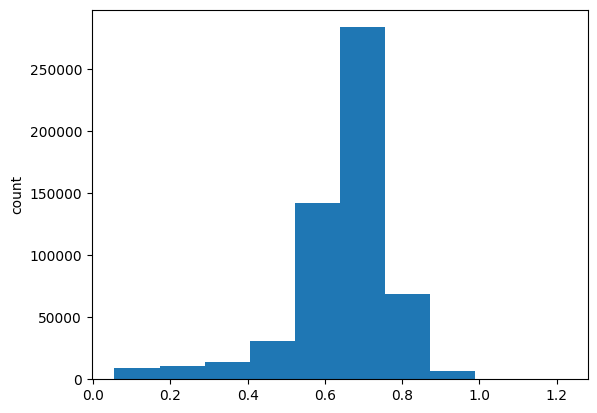

torch.Size([102527])


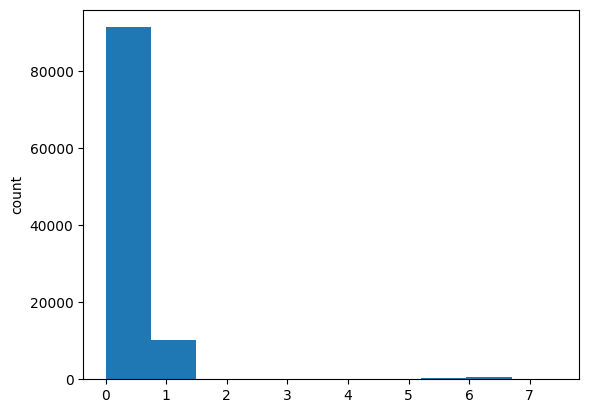

In [34]:
#print histogram on eta

eta_his = data_good_filted[:,0]
print(eta_his.shape)

plt.hist(eta_his)
#plt.xlabel("eta_number")
plt.ylabel("count")
plt.show()

eta_his = data_bad_filted[:,0]
print(eta_his.shape)

plt.hist(eta_his)
#plt.xlabel("eta_number")
plt.ylabel("count")
plt.show()